In [ ]:
import numpy as np
import pandas as pd
from nilearn import image, input_data, plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from scipy import stats
import os
import pickle
from pathlib import Path
from nilearn.datasets import fetch_atlas_harvard_oxford

First We Setup Project Directory Structure

In [ ]:
# Create directory structure
project_dir = Path('fmri_project')
checkpoints_dir = project_dir / 'checkpoints'
results_dir = project_dir / 'results'

# Create directories if they don't exist
for dir_path in [checkpoints_dir, results_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

def save_checkpoint(data, filename):
    """Save data to checkpoint file"""
    filepath = checkpoints_dir / filename
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Checkpoint saved: {filepath}")

def load_checkpoint(filename):
    """Load data from checkpoint file"""
    filepath = checkpoints_dir / filename
    if filepath.exists():
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    return None

Create events DataFrame from the trial information in the original "README" file

In [ ]:
# Check if events DataFrame already exists
events = load_checkpoint('events.pkl')

if events is None:
    # Create events DataFrame with timing information
    events = pd.DataFrame({
        'onset': [0, 60, 120, 180, 240, 300, 360, 420, 480, 540],
        'duration': [30] * 10,
        'emotion': ['calm', 'afraid', 'delighted', 'depressed',
                    'excited', 'delighted', 'depressed', 'calm',
                    'excited', 'afraid']
    })

    # Map emotions to valence categories
    valence_mapping = {
        'calm': 'neutral',
        'afraid': 'negative',
        'delighted': 'positive',
        'depressed': 'negative',
        'excited': 'positive'
    }
    events['trial_type'] = events['emotion'].map(valence_mapping)

    # Save events DataFrame
    save_checkpoint(events, 'events.pkl')
else:
    print("Loaded existing events DataFrame")

Creat Region of interest(ROI) masks

In [ ]:
# Check if ROI masks already exist
roi_masks = load_checkpoint('roi_masks.pkl')

if roi_masks is None:
    # Fetch Harvard-Oxford atlases
    cortical = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

    # Create ROI masks
    roi_masks = {
        # Subcortical regions
        'amygdala_left': image.math_img('img == 10', img=subcortical.maps),
        'amygdala_right': image.math_img('img == 20', img=subcortical.maps),
        'hippocampus_left': image.math_img('img == 9', img=subcortical.maps),
        'hippocampus_right': image.math_img('img == 19', img=subcortical.maps),

        # Cortical regions
        'acc': image.math_img('img == 29', img=cortical.maps),
        'sup_frontal_gyrus': image.math_img('img == 3', img=cortical.maps),
        'mid_frontal_gyrus': image.math_img('img == 4', img=cortical.maps),
    }

    # Create bilateral masks
    bilateral_pairs = [
        ('amygdala', 'amygdala_left', 'amygdala_right'),
        ('hippocampus', 'hippocampus_left', 'hippocampus_right'),
    ]

    # Combine bilateral pairs
    for name, left, right in bilateral_pairs:
        roi_masks[f'{name}_bilateral'] = image.math_img(
            "img1 + img2",
            img1=roi_masks[left],
            img2=roi_masks[right]
        )

    # Save ROI masks
    save_checkpoint(roi_masks, 'roi_masks.pkl')
else:
    print("Loaded existing ROI masks")

Process individual subjects and save the results

In [ ]:
# Check if subject results already exist
all_subject_contrasts = load_checkpoint('subject_contrasts.pkl')
all_subject_roi_signals = load_checkpoint('subject_roi_signals.pkl')

if all_subject_contrasts is None or all_subject_roi_signals is None:
    # Initialize lists to store results
    n_subjects = 40
    all_subject_contrasts = []
    all_subject_roi_signals = []

    # Process each subject
    for subject_id in range(1, n_subjects + 1):
        subject_id_str = f'{subject_id:02d}'
        print(f'Processing subject {subject_id_str}...')

        # Check if individual subject results exist
        subject_results = load_checkpoint(f'subject_{subject_id_str}_results.pkl')

        if subject_results is None:
            # Load subject data
            func_file = f'ds005700/sub-{subject_id_str}/func/sub-{subject_id_str}_task-fe_bold.nii.gz'
            anat_file = f'ds005700/sub-{subject_id_str}/anat/sub-{subject_id_str}_T1w.nii.gz'

            func_img = image.load_img(func_file)
            anat_img = image.load_img(anat_file)

            # Create and fit first-level model
            model = FirstLevelModel(
                t_r=2.02697,  # Time repetition from .json file
                noise_model='ar1',
                standardize=True,
                hrf_model='spm',
                drift_model='cosine'
            )

            model.fit(func_img, events)

            # Define and compute contrasts
            contrasts = {
                'positive_vs_neutral': 'positive - neutral',
                'negative_vs_neutral': 'negative - neutral',
                'positive_vs_negative': 'positive - negative'
            }

            contrast_maps = {}
            for contrast_id, contrast_def in contrasts.items():
                contrast_maps[contrast_id] = model.compute_contrast(contrast_def)

            # Extract ROI signals
            roi_signals = {}
            for roi_name, roi_mask in roi_masks.items():
                masker = input_data.NiftiMasker(mask_img=roi_mask)
                roi_signals[roi_name] = masker.fit_transform(func_img)

            # Save individual subject results
            subject_results = {'contrasts': contrast_maps, 'roi_signals': roi_signals}
            save_checkpoint(subject_results, f'subject_{subject_id_str}_results.pkl')
        else:
            print(f"Loaded existing results for subject {subject_id_str}")
            contrast_maps = subject_results['contrasts']
            roi_signals = subject_results['roi_signals']

        all_subject_contrasts.append(contrast_maps)
        all_subject_roi_signals.append(roi_signals)

    # Save all subject results
    save_checkpoint(all_subject_contrasts, 'subject_contrasts.pkl')
    save_checkpoint(all_subject_roi_signals, 'subject_roi_signals.pkl')
else:
    print("Loaded existing subject results")


Create the design matrix for my experiment and perform the second-level group analysis

Running group analysis for positive_vs_negative...


/var/folders/nb/dkf_lr4s16gc637vh_y3vzv40000gn/T/ipykernel_17853/3076157935.py:51: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_img(
/var/folders/nb/dkf_lr4s16gc637vh_y3vzv40000gn/T/ipykernel_17853/3076157935.py:51: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_img(
/var/folders/nb/dkf_lr4s16gc637vh_y3vzv40000gn/T/ipykernel_17853/3076157935.py:51: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_img(
/var/folders/nb/dkf_lr4s16gc637vh_y3vzv40000gn/T/ipykernel_17853/3076157935.py:51: FutureWarning: From r

Checkpoint saved: fmri_project/checkpoints/group_results.pkl


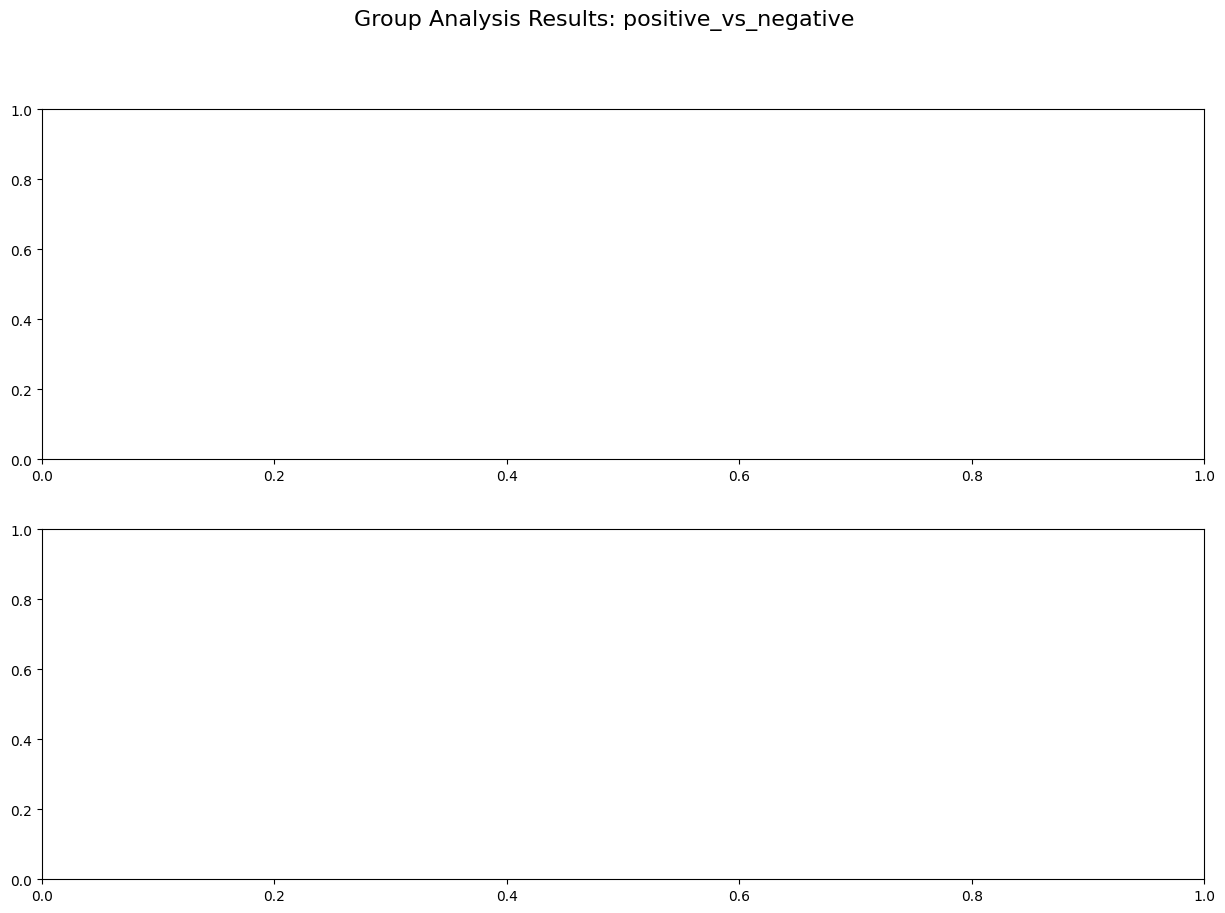

In [32]:
import numpy as np
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
import matplotlib.pyplot as plt
from nilearn import plotting, image

# Create design matrix for second-level analysis
n_subjects = 40
design_matrix = pd.DataFrame({
    'intercept': np.ones(n_subjects),
})

# Initialize second-level model
second_level_model = SecondLevelModel()

# Function to perform group analysis for a specific contrast
def run_group_analysis(contrast_maps, contrast_name, design_matrix):
    """
    Perform second-level analysis for a specific contrast.

    Parameters:
    -----------
    contrast_maps : list
        List of first-level contrast maps for all subjects
    contrast_name : str
        Name of the contrast being analyzed
    design_matrix : pd.DataFrame
        Design matrix for the second-level analysis

    Returns:
    --------
    tuple
        (z_map, p_map) containing the statistical maps
    """
    # Extract and preprocess the specific contrast maps for all subjects
    contrast_maps_list = []

    # Get the first map to use as reference
    first_map = contrast_maps[0][contrast_name]
    reference_affine = first_map.affine
    reference_shape = first_map.shape[:3]  # Exclude time dimension if present

    for subject_contrasts in contrast_maps:
        contrast_img = subject_contrasts[contrast_name]

        # Ensure 3D
        if len(contrast_img.shape) == 4:
            contrast_img = image.index_img(contrast_img, 0)

        # Resample to match reference
        resampled_img = image.resample_img(
            contrast_img,
            target_affine=reference_affine,
            target_shape=reference_shape,
            interpolation='continuous'
        )

        contrast_maps_list.append(resampled_img)

    # Fit the second-level model
    second_level_model.fit(contrast_maps_list, design_matrix=design_matrix)

    # Compute the group-level contrast
    # Using intercept as we're interested in the group mean effect
    z_map = second_level_model.compute_contrast(output_type='z_score')
    p_map = second_level_model.compute_contrast(output_type='p_value')

    return z_map, p_map

# Function to visualize results
def plot_group_results(z_map, p_map, contrast_name, threshold=3.1):

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    plt.suptitle(f'Group Analysis Results: {contrast_name}', fontsize=16)

    # Statistical map with brain sections
    # display = plotting.plot_stat_map(
    #     z_map,
    #     display_mode='mosaic',
    #     cut_coords=4,
    #     threshold=3.1,  # threshold corresponding to p < 0.001
    #     colorbar=True,
    #
    #     axes=axes[0]
    # )


    # plt.tight_layout()



    # Create figure with multiple views
    fig = plt.figure(figsize=(15, 5))

    # Plot sagittal, coronal, and axial views
    display = plotting.plot_stat_map(
        z_map,
        threshold=threshold,
        display_mode='ortho',
        #cut_coords=[0, 0, 0], # need to find the best way to see the differences.
        title=f'Group-level {contrast_name}\n'
              f'(threshold: z>{threshold})',
        figure=fig
    )



    # Save the figure
    plt.savefig(f'results/group_analysis_{contrast_name}(Z scores).png', dpi=300, bbox_inches='tight')
    plt.close()



# Run group analysis for each contrast
contrasts_to_analyze = [
    # 'positive_vs_neutral',
    # 'negative_vs_neutral',
    'positive_vs_negative'
]

group_results = {}
for contrast_name in contrasts_to_analyze:
    print(f"Running group analysis for {contrast_name}...")
    z_map, p_map = run_group_analysis(all_subject_contrasts, contrast_name, design_matrix)
    group_results[contrast_name] = (z_map, p_map)

    # Visualize results
    plot_group_results(z_map, p_map, contrast_name)

    # Save the statistical maps
    # z_map.to_filename(f'results/group_zmap_{contrast_name}.nii.gz')
    # p_map.to_filename(f'results/group_pmap_{contrast_name}.nii.gz')

# Save group results
save_checkpoint(group_results, 'group_results.pkl')